# TP3 - Regresion Logistica

**Alumna**: Lucia Berard

**Fecha**: 06/04/2025


[Link a Google Colab](https://colab.research.google.com/drive/1b3oCFJ9jkZaq6sX-_WGJoaA2GCgv4ZTs?usp=sharing)


---

## Consigna

Se desea desarrollar un clasificador de imagenes de gatos y perros utilizando regresión logística. Para ello descargar la base de datos dog-and-cat-classification-dataset de kaggle.

Tip: La siguiente instrucción puede ayudar con la descarga

`kagglehub.dataset_download("bhavikjikadara/dog-and-cat-classification-dataset")`

In [2]:
%pip install kagglehub

You should consider upgrading via the '/Users/luberard/Documents/fiuba/taller-procesamiento-tde/venv-taller/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [22]:
import kagglehub
import os
import numpy as np
import matplotlib.pyplot as plt
import random
from sklearn.model_selection import train_test_split
from PIL import Image, ImageFile
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import PolynomialFeatures

ImageFile.LOAD_TRUNCATED_IMAGES = True

In [25]:

path = kagglehub.dataset_download("bhavikjikadara/dog-and-cat-classification-dataset")

print("Path para los archivos del dataset:", path)

Path para los archivos del dataset: /Users/luberard/.cache/kagglehub/datasets/bhavikjikadara/dog-and-cat-classification-dataset/versions/1


----
## a) Analisis

1. Calcular la función inversa $ \sigma^{-1}(p) $ con $ p \in (0,1) $.  
2.  Sea $ p = \sigma(z) $ la función sigmoide, calcular la derivada $ \sigma'(z) $. 
**Nota:** Me parece que si se expresa el resultado en función de $ p $, el resultado se simplifica bastante.  


3.  Hallar una expresión analítica para la función costo y su gradiente. **Nota:** Tenga en cuenta el modelo asociado a una regresión logística de dos clases.  


### 1) Inversa de la sigmoide

La función sigmoide está dada por:

$$
\sigma(z) = \frac{1}{1 + e^{-z}}
$$

Para encontrar su inversa, se despeja $z$ en términos de $p$, con $p = \sigma(z) \in (0,1)$:

$$
p = \frac{1}{1 + e^{-z}} \Rightarrow p(1 + e^{-z}) = 1 \Rightarrow p + p e^{-z} = 1 \Rightarrow p e^{-z} = 1 - p
$$

Se aplica logaritmo natural:

$$
\ln(p e^{-z}) = \ln(1 - p) \Rightarrow \ln p - z = \ln(1 - p) \Rightarrow z = \ln\left( \frac{p}{1 - p} \right)
$$

Por lo tanto, la función inversa es:

$$
\sigma^{-1}(p) = \ln\left( \frac{p}{1 - p} \right)
$$





### 2) Derivada de la sigmoide

Partiendo de:

$$
\sigma(z) = \frac{1}{1 + e^{-z}} = (1 + e^{-z})^{-1}
$$

Se aplica la regla de la cadena:

$$
\sigma'(z) = - (1 + e^{-z})^{-2} \cdot (-e^{-z}) = \frac{e^{-z}}{(1 + e^{-z})^2}
$$

Ahora, reescribiendo en función de $p = \sigma(z)$:

$$
\sigma(z) = p = \frac{1}{1 + e^{-z}} \Rightarrow 1 - p = \frac{e^{-z}}{1 + e^{-z}}
$$

Entonces:

$$
\sigma'(z) = p(1 - p)
$$

Es decir:

$$
\sigma'(z) = \sigma(z)(1 - \sigma(z))
$$





### 3) Gradiente de la función de costo

La función de costo log-loss para una sola muestra $(X_i, Y_i)$ es:

$$
\ell(w, b) = - \left[ Y_i \log(p_i) + (1 - Y_i) \log(1 - p_i) \right]
$$

donde:

$$
p_i = \sigma(w^T X_i + b) = \frac{1}{1 + e^{-(w^T X_i + b)}}
$$

Se quiere hallar el gradiente respecto a $w$ y $b$.

**Gradiente respecto a $w$:**

Se sabe que:

$$
\frac{\partial p_i}{\partial w} = p_i (1 - p_i) X_i
\quad \text{y} \quad
\frac{\partial (1 - p_i)}{\partial w} = - p_i (1 - p_i) X_i
$$

Al aplicar la regla de la cadena:

$$
\frac{\partial \ell}{\partial w} = -\left[ Y_i \cdot \frac{1}{p_i} \cdot \frac{\partial p_i}{\partial w} + (1 - Y_i) \cdot \frac{1}{1 - p_i} \cdot \frac{\partial (1 - p_i)}{\partial w} \right]
$$

Sustituyendo derivadas:

$$
\frac{\partial \ell}{\partial w} = -\left[ Y_i \cdot \frac{1}{p_i} \cdot p_i (1 - p_i) X_i + (1 - Y_i) \cdot \frac{1}{1 - p_i} \cdot (-p_i (1 - p_i)) X_i \right]
$$

Simplificando:

$$
\frac{\partial \ell}{\partial w} = -\left[ Y_i (1 - p_i) X_i - (1 - Y_i) p_i X_i \right] = (p_i - Y_i) X_i
$$

**Gradiente respecto a $b$:**

Se sabe que:

$$
\frac{\partial p_i}{\partial b} = p_i (1 - p_i)
$$

Entonces:

$$
\frac{\partial \ell}{\partial b} = -\left[ Y_i \cdot \frac{1}{p_i} \cdot p_i (1 - p_i) + (1 - Y_i) \cdot \frac{1}{1 - p_i} \cdot (-p_i (1 - p_i)) \right] = (p_i - Y_i)
$$

**Gradiente completo:**

$$
\nabla \ell(w, b) =
\begin{bmatrix}
\frac{\partial \ell}{\partial w} \\
\frac{\partial \ell}{\partial b}
\end{bmatrix}
=
\begin{bmatrix}
(p_i - Y_i) X_i \\
(p_i - Y_i)
\end{bmatrix}
$$

Este resultado se utiliza para aplicar descenso por gradiente en la regresión logística binaria.



----
## b) Pre - Procesamiento
### 1. Las imágenes poseen diferentes tamaños. Convertirlas todas a $ 16 \times 16 $ utilizando `resize` (PIL). 
### 2. Las imágenes también poseen diferentes formatos. Convertirlas todas a escala de grises.  

Se realizaron los dos puntos en un mismo codigo ya que se puede convertir en tamaño y a escala de grises directamente en la misma funcion de PIL, logrando mayor eficiencia del recorrido del dataset:

> ```python
> Image.open(img_path).convert("L").resize((16, 16))
> ```

donde L es la escala de grises.


Ademas se creo la funcion `es_imagen_valida(path)` porque al correr el codigo figuraba el siguiente error:

> ```bash
> python3.9/site-packages/PIL/TiffImagePlugin.py:949: UserWarning: Truncated File Read warnings.warn(str(msg))
> ```


Esta funcion es para filtrar los archivos corruptos del dataset. 

In [41]:

def es_imagen_valida(path):
    try:
        with Image.open(path) as img:
            img.verify()  # Verifica si la imagen puede abrirse correctamente
        return True
    except:
        return False


In [42]:

image_dir = os.path.expanduser(path)
cat_dir = os.path.join(image_dir, "PetImages/Cat")
dog_dir = os.path.join(image_dir, "PetImages/Dog")

# Listo todos los nombres de archivos dentro del directorio PetImages/Cat para luego poder acceder a cada path
# por ejemplo: ["cat1.jpg", "cat2.jpg", "Thumbs.db", ...]
cat_images = [f for f in os.listdir(cat_dir) if es_imagen_valida(os.path.join(cat_dir, f))]
dog_images = [f for f in os.listdir(dog_dir) if es_imagen_valida(os.path.join(dog_dir, f))]

images = []
labels = []

for fname in cat_images:
    #  Construyo la ruta completa al archivo fname, que viene de cat_images
    # Ejemplo: ".../PetImages/Cat/cat1.jpg"
    img_path = os.path.join(cat_dir, fname)
    img = Image.open(img_path).convert("L").resize((16, 16))
    images.append(img)
    labels.append("cat")

for fname in dog_images:
    img_path = os.path.join(dog_dir, fname)
    img = Image.open(img_path).convert("L").resize((16, 16))
    images.append(img)
    labels.append("dog")

### 3. Mostrar 5 imágenes.  


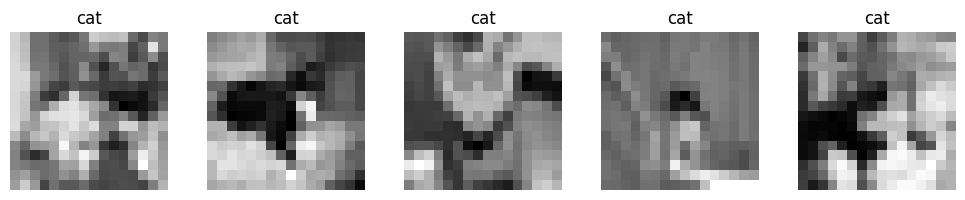

In [43]:
plt.figure(figsize=(10, 2))

for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(images[i], cmap='gray')  # cmap='gray' para escala de grises
    plt.title(labels[i])
    plt.axis('off')

plt.tight_layout()
plt.show()

### 4. Utilice el comando `train_test_split` (sklearn) para definir dos conjuntos de datos. El conjunto de entrenamiento debe contener 20,000 muestras; el resto será de testeo.  

Segun la documentacion de sklearn [`train_test_split`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) es un comando que sirve para dividir los datos en conjuntos de entrenamiento y testeo (y opcionalmente validación).

✅ ¿Qué hace?
Divide los datos (images y labels) en dos conjuntos:
- Entrenamiento: X_train (imágenes), y_train (etiquetas)
- Testeo: X_test, y_test

✅ ¿Qué significan los parámetros?

- images: Lista de imágenes (inputs)
- labels: Lista de etiquetas ("cat" o "dog")
- train_size=20000: Se asignan exactamente 20,000 muestras para entrenamiento
- random_state=42: Fija la aleatoriedad para que los resultados sean reproducibles
- stratify=labels: Mantiene el mismo porcentaje de gatos/perros en train y test

✅ ¿Qué devuelve?
- X_train: lista de 20,000 imágenes
- X_test: el resto de imágenes
- y_train: etiquetas correspondientes a X_train
- y_test: etiquetas correspondientes a X_test

🔹 Muestras del set de entrenamiento X_train:


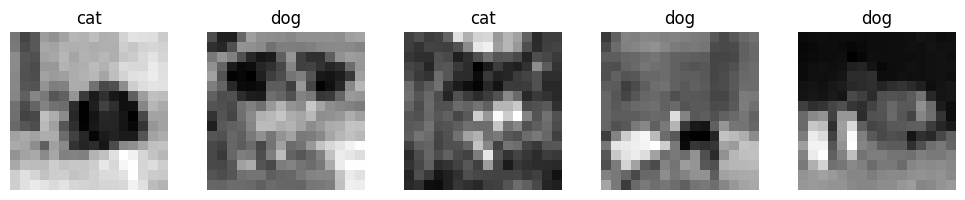

🔹 Muestras del set de testeo X_test:


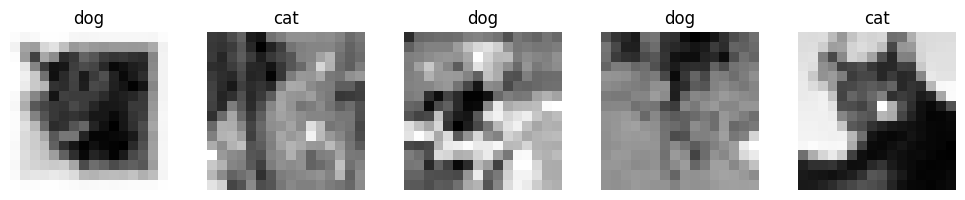

In [44]:
# Asegurarse que hay suficientes muestras
assert len(images) >= 20000, "Necesitás al menos 20,000 imágenes."

# Dividir con tamaño de entrenamiento fijo
# Dividir los datos en entrenamiento (20,000) y testeo (resto), manteniendo balance entre clases
X_train, X_test, y_train, y_test = train_test_split(
    images,
    labels,
    train_size=20000,
    random_state=42,
    stratify=labels  # opcional, mantiene el balance entre 'cat' y 'dog'
)

# ✅ Mostrar 5 imágenes random del set de entrenamiento
print("🔹 Muestras del set de entrenamiento X_train:")
plt.figure(figsize=(10, 2))
for i, idx in enumerate(random.sample(range(len(X_train)), 5)):
    plt.subplot(1, 5, i+1)
    plt.imshow(X_train[idx], cmap='gray')
    plt.title(y_train[idx])
    plt.axis('off')
plt.tight_layout()
plt.show()

# ✅ Mostrar 5 imágenes random del set de testeo
print("🔹 Muestras del set de testeo X_test:")
plt.figure(figsize=(10, 2))
for i, idx in enumerate(random.sample(range(len(X_test)), 5)):
    plt.subplot(1, 5, i+1)
    plt.imshow(X_test[idx], cmap='gray')
    plt.title(y_test[idx])
    plt.axis('off')
plt.tight_layout()
plt.show()


----
## c) Clasificacion
###  1. Utilizando `LogisticRegression` (sklearn), realizar una regresión logística sin regularización.  

LogisticRegression trabaja con vectores de números, no con objetos PIL.Image.

❌ ¿Qué pasa si NO convierto las imágenes?
Si intento pasar PIL.Image directamente al modelo, se obtiene un error tipo:
ValueError: Expected 2D array, got 1D or object array instead.
Esto pasa porque los modelos no saben cómo interpretar un objeto de imagen. Necesitan vectores/matrices numéricas para trabajar.

🧠 ¿Qué significa cada parámetro?
- penalty=None: No se aplica regularización (ni L2 ni L1)
- solver='saga': Optimizador recomendado para datasets grandes y sin penalización
- max_iter=1000: Número máximo de iteraciones para que el modelo converja

El siguiente algoritmo ajusta los pesos del modelo para predecir la probabilidad de que una imagen sea "dog" (1) o "cat" (0), basándose en sus 256 píxeles.

In [45]:
# Convertir imágenes a vectores de 256 píxeles (16x16)
X_train_np = np.array([np.array(img).flatten() for img in X_train])
X_test_np  = np.array([np.array(img).flatten() for img in X_test])

# Etiquetas: 0 = cat, 1 = dog
y_train_np = np.array([1 if label == "dog" else 0 for label in y_train])
y_test_np  = np.array([1 if label == "dog" else 0 for label in y_test])

# penalty='none' = sin regularización, saga = optimizador para datasets grandes
model = LogisticRegression(penalty=None, solver='saga', max_iter=1000)

# Entrenamiento
model.fit(X_train_np, y_train_np)

LogisticRegression(max_iter=1000, penalty=None, solver='saga')

### 2. Implementar una función que permita calcular la **accuracy** a partir de la salida de `predict`. Reportar la **accuracy** de entrenamiento y testeo.  

Teniendo en cuenta que la formula es:

> Accuracy = (Cantidad de predicciones correctas) ÷ (Cantidad total de muestras)

se armo la funcion `compute_accuracy()`

🧠 ¿Qué hace?

- y_true == y_pred genera un array booleano (True donde acierta, False donde no).

- np.mean(...) convierte esos True/False a 1 y 0, y calcula el promedio.

In [46]:
def compute_accuracy(y_true, y_pred):
    return np.mean(y_true == y_pred)


In [47]:

# Predicciones
# Uso el modelo entrenado para predecir etiquetas (0 = cat, 1 = dog) para cada imagen del set de entrenamiento y testeo.
y_train_pred = model.predict(X_train_np)
y_test_pred  = model.predict(X_test_np)

# Accuracy
# Comparo las etiquetas verdaderas (y_train_np, y_test_np) con las predichas y calculo el porcentaje de aciertos.
acc_train = compute_accuracy(y_train_np, y_train_pred)
acc_test  = compute_accuracy(y_test_np, y_test_pred)

print(f"Accuracy en entrenamiento: {acc_train:.4f}")
print(f"Accuracy en testeo: {acc_test:.4f}")


Accuracy en entrenamiento: 0.5850
Accuracy en testeo: 0.5692


Otra opcion es utilizar la funcion de la libreria de `sklearn`: `accuracy_score`. Devuelve lo mismo, pero es más clara y estándar para reportar métricas. 

In [ ]:
# from sklearn.metrics import accuracy_score

# accuracy_score(y_true, y_pred)

### 3. Implementar una función que permita calcular la **cross-entropy** a partir de la salida de `predict_log_proba`. Reportar la **cross-entropy** de entrenamiento y testeo. **Nota:** Por un tema de continuidad, asuma que $ p \log(q) = 0 $ si $ p = q = 0 $.  


El método `predict_log_proba(X)` de un modelo como LogisticRegression devuelve las log-probabilidades predichas para cada clase, en vez de las probabilidades “normales”. Es decir que este metodo devuelve los logaritmos naturales de esas probabilidades.

🧠 ¿Por qué usar log-probabilidades?

- Evita errores numéricos: por ejemplo log(1e-15) es manejable; 1e-15 puede redondearse a 0.
- Suma en lugar de multiplicación: En muchas tareas calcular la probabilidad conjunta implica productos, pero en espacio logaritmico eso se convierte en sumas
- Cross-entropy: Puede calcularse directamente como -log(p_clase_correcta)

🧠 ¿Qué es la cross-entropy?

La cross-entropy (entropía cruzada) es una función de pérdida usada para medir qué tan cerca están las predicciones probabilísticas de un modelo respecto a las etiquetas verdaderas


En clasificacion binaria, dado:

- Etiqueta verdadera: $y \in \{0, 1\}$
- Probabilidad estimada: $\hat{p} = P(y = 1 \mid x)$

La cross-entropy se define como:

$$
H(y, \hat{p}) = -\left[ y \cdot \log(\hat{p}) + (1 - y) \cdot \log(1 - \hat{p}) \right]
$$

Esta fórmula penaliza más fuertemente cuando el modelo **se equivoca con mucha confianza**.

El método `predict_log_proba(X)` devuelve directamente los **logaritmos de las probabilidades** para cada clase, es decir:

$$
[\log(\hat{P}(y=0 \mid x)), \log(\hat{P}(y=1 \mid x))]
$$

Esto permite calcular directamente:

$$
\text{cross-entropy} = -\log(\hat{P}(y = \text{clase correcta} \mid x))
$$

Es decir, sólo necesitamos mirar la log-probabilidad de la clase correcta y luego **promediar sobre todas las muestras**.


In [48]:
def cross_entropy(y_true, log_probs):
    ce = 0
    for i in range(len(y_true)):
        p = y_true[i]  # clase verdadera (0 o 1)
        log_q = log_probs[i][p]  # log(p(clase correcta))
        ce += -log_q
    return ce / len(y_true)


🔎 ¿Qué hace?

- y_true[i]: etiqueta verdadera de la muestra i (0 o 1).
- log_probs[i][p]: accede a la log-probabilidad estimada por el modelo para la clase verdadera.
- -log_q: es el valor de pérdida para esa muestra.
- Se acumulan todas las pérdidas y luego se promedia.

In [49]:
# Log-probabilidades
train_log_proba = model.predict_log_proba(X_train_np)
test_log_proba  = model.predict_log_proba(X_test_np)

# Calcular cross-entropy promedio
ce_train = cross_entropy(y_train_np, train_log_proba)
ce_test  = cross_entropy(y_test_np, test_log_proba)

print(f"Cross-entropy en entrenamiento: {ce_train:.4f}")
print(f"Cross-entropy en testeo:       {ce_test:.4f}")

Cross-entropy en entrenamiento: 0.6725
Cross-entropy en testeo:       0.6840


Otra opcion disponible es la funcion de la libreria `sklearn`: `log_loss`. Es equivalente, pero log_loss espera:
- y_true (0 o 1)
- y_pred_proba (probabilidades, no log)

asique como se pedia usar log_proba no se podia ya que log_loss usa proba, pero son intercambiables si se hace np.exp(log_probs).

### 4. Crear una imagen de $ 16 \times 16 $ a partir del consejero de la guía y clasificarla.  

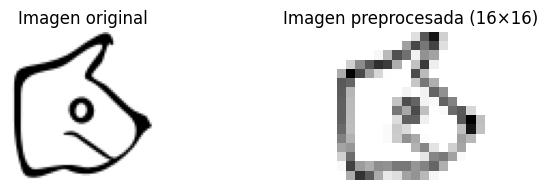

Es un gato 🐱


In [50]:
img_original = Image.open("consejero.png")

# Preprocesamiento: escala de grises y resize a 16x16
img_preprocessed = img_original.convert("L").resize((16, 16))

plt.figure(figsize=(8, 2))

# Imagen original
plt.subplot(1, 2, 1)
plt.imshow(img_original)
plt.title("Imagen original")
plt.axis("off")

# Imagen preprocesada
plt.subplot(1, 2, 2)
plt.imshow(img_preprocessed, cmap="gray")
plt.title("Imagen preprocesada (16×16)")
plt.axis("off")

plt.tight_layout()
plt.show()

# Clasificar
img_array = np.array(img_preprocessed).flatten().reshape(1, -1)
pred = model.predict(img_array)
print("Es un perro 🐶" if pred[0] == 1 else "Es un gato 🐱")


----
## d) Regularizacion

Utilice un **mapa polinómico de orden 2** y un término de penalización para regularizar el problema. Indicar la **accuracy** tanto para el entrenamiento como el testeo. 

**Nota:** Una regresión con muchos parámetros puede tardar un tiempo. Un buen tip es configurar `max_iter` en un valor muy bajo para probar el código y, una vez funcionando, darle un valor razonable.

[`PolinomialFeatures`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html) genera nuevas variables combinando las variables numéricas originales elevándolas a potencias y multiplicándolas entre sí (en este caso hasta grado 2). Se usa para expandir el espacio de características y permitir que un modelo lineal (como regresión lineal) pueda capturar relaciones no lineales entre las variables.

[`LogisticRegression`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) es un modelo lineal de clasificación que predice la probabilidad de que una muestra pertenezca a una clase
- penalty='l2': Aplica regularización Ridge (L2), para evitar overfitting. Penaliza pesos grandes.
- C=1.0: Controla la fuerza de regularización: menor C → más regularización.
- solver='saga': Optimizador recomendado para datasets grandes o dispersos. Funciona bien con l2.
- max_iter=100: Límite de iteraciones para entrenar el modelo. Si el modelo no converge, aumentá este valor.

🧠 ¿Por qué usar PolynomialFeatures + LogisticRegression?
- La regresión logística por sí sola es lineal, no puede aprender límites curvos.
- Al aplicar un mapa polinómico, se expande el espacio de entrada → el modelo puede representar relaciones no lineales.
- La regularización (penalty='l2') previene el overfitting por la gran cantidad de nuevas features.


In [51]:
# Crear el transformador polinómico
poly = PolynomialFeatures(degree=2, include_bias=False)

# Aplicar a los datos (X ya son arrays aplanados de 256 features)
X_train_poly = poly.fit_transform(X_train_np)
X_test_poly  = poly.transform(X_test_np)

print(f"Cantidad de features antes: {X_train_np.shape[1]}")
print(f"Cantidad de features después del mapa polinómico: {X_train_poly.shape[1]}")

# Crear el modelo con regularización L2 (default), C = 1 (fuerza de regularización)
model_poly = LogisticRegression(
    penalty='l2',
    solver='saga',
    max_iter=100,
    C=1.0  # menor C = más regularización
)

model_poly.fit(X_train_poly, y_train_np)

y_train_pred_poly = model_poly.predict(X_train_poly)
y_test_pred_poly  = model_poly.predict(X_test_poly)

acc_train_poly = compute_accuracy(y_train_np, y_train_pred_poly)
acc_test_poly  = compute_accuracy(y_test_np, y_test_pred_poly)

print(f"🔵 Accuracy entrenamiento (mapa polinómico): {acc_train_poly:.4f}")
print(f"🟢 Accuracy testeo (mapa polinómico): {acc_test_poly:.4f}")

Cantidad de features antes: 256
Cantidad de features después del mapa polinómico: 33152


/Users/luberard/Documents/fiuba/taller-procesamiento-tde/venv-taller/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


🔵 Accuracy entrenamiento (mapa polinómico): 0.6949
🟢 Accuracy testeo (mapa polinómico): 0.6497



----
## e) Curva ROC

A partir de la salida de `predict_proba` del conjunto de testeo, implementar la **curva ROC**. Comparar las **ROC** de los clasificadores con y sin regularización con la de uno que decide al azar.

La idea es graficar la curva ROC (Receiver Operating Characteristic) para:

- Un modelo sin regularización
- Un modelo con regularización (polinómico)
- Un modelo aleatorio (referencia)

La curva ROC muestra la relación entre:

- TPR (True Positive Rate) = Sensibilidad = $\frac{TP}{TP+FN}$

- FPR (False Positive Rate) = $\frac{FP}{FP+TN}$
 

a medida que se varía el umbral de decisión sobre las probabilidades.

 | Sigla	| Significado	| Qué mide |
 |---|---|---|
| TP	| True Positives| 	Casos que eran dog y fueron correctamente clasificados como dog| 
| TN	| True Negatives| 	Casos que eran cat y fueron correctamente clasificados como cat| 
| FP	| False Positives| 	Casos que eran cat pero el modelo los predijo como dog| 
| FN	| False Negatives| 	Casos que eran dog pero el modelo los predijo como cat| 

Se realizo la funcion de cero para entender como funcionaba pero otra opcion es utilizar la funcion de la libreria `sklearn`: `roc_curve` que tambien devuelve los umbrales, además de FPR y TPR. 

In [ ]:
# from sklearn.metrics import roc_curve

# fpr, tpr, thresholds = roc_curve(y_true, y_score)

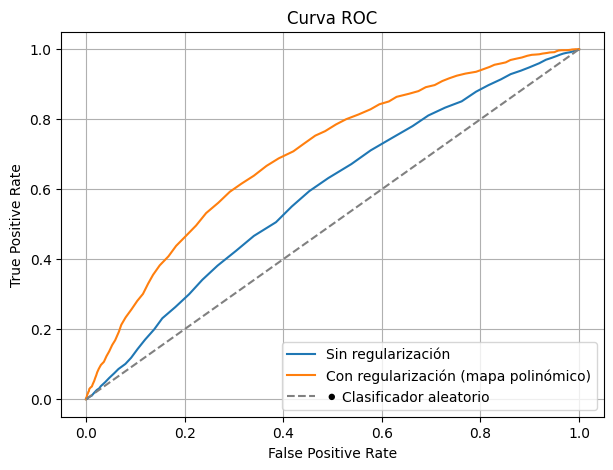

In [52]:
# Probabilidades predichas para clase "dog" 
proba_test_no_reg  = model.predict_proba(X_test_np)[:, 1]
proba_test_poly_reg = model_poly.predict_proba(X_test_poly)[:, 1]

def compute_roc(y_true, y_score, thresholds=np.linspace(0, 1, 100)):
    tpr = []  # true positive rate
    fpr = []  # false positive rate
    # Recorro distintos umbrales de decisión:
    # Para cada thresh (ej: 0.1, 0.2, ..., 0.9):
        # Clasifico como 1 (dog) si la probabilidad es mayor o igual al umbral
        # Clasifico como 0 (cat) en otro caso
    for thresh in thresholds:
        y_pred = (y_score >= thresh).astype(int)
        TP = np.sum((y_pred == 1) & (y_true == 1))
        FP = np.sum((y_pred == 1) & (y_true == 0))
        FN = np.sum((y_pred == 0) & (y_true == 1))
        TN = np.sum((y_pred == 0) & (y_true == 0))

        tpr.append(TP / (TP + FN + 1e-8)) # se agrego 1e-8 al denominador para evitar divisiones por cero
        fpr.append(FP / (FP + TN + 1e-8))
    return fpr, tpr

# Modelo sin regular
fpr_no_reg,  tpr_no_reg  = compute_roc(y_test_np, proba_test_no_reg)
 
# Modelo mapa polinomico
fpr_poly,    tpr_poly    = compute_roc(y_test_np, proba_test_poly_reg)

# Clasificador aleatorio: ROC ideal sería una diagonal
fpr_rand = np.linspace(0, 1, 100)
tpr_rand = fpr_rand

import matplotlib.pyplot as plt

plt.figure(figsize=(7, 5))
plt.plot(fpr_no_reg,  tpr_no_reg,  label="Sin regularización")
plt.plot(fpr_poly,    tpr_poly,    label="Con regularización (mapa polinómico)")
plt.plot(fpr_rand,    tpr_rand,    '--', label="⚫ Clasificador aleatorio", color='gray')

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Curva ROC")
plt.legend()
plt.grid(True)
plt.show()


🔵 Sin regularización:

- La curva queda cerca de la diagonal aleatoria, lo que indica que el modelo no distingue muy bien entre gatos y perros.

- Su performance es apenas mejor que adivinar al azar.

🟠 Con regularización + mapa polinómico:

- La curva está claramente por encima de la curva azul, lo que muestra una mejora significativa.

- Esto significa que el modelo captura relaciones no lineales entre píxeles que el modelo simple no ve.

- Tiene mayor TPR para un mismo FPR, lo que es deseable.

⚫ Clasificador aleatorio (diagonal):

- Es el baseline: un modelo que elige al azar (por ejemplo, tira una moneda).

- Cualquier modelo útil debe estar por encima de esta línea.


✅ Conclusión:

El modelo con mapa polinómico + regularización generaliza mejor, aprendiendo patrones más complejos sin sobreajustarse.

La curva ROC más arriba → mejor modelo.